In [48]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(".."))

In [65]:
from utils.loader import load_data_with_logReturn

data_clean = load_data_with_logReturn("../stocks/AAPL.csv")

In [66]:
class FIRFilter:
    def __init__(self, coefficients):
        self.coefficients = np.array(coefficients)

    def filter(self, signal):
        if isinstance(signal, pd.Series):
            # pad on the left to prevent future leakage
            padded = np.pad(signal.values, (len(self.coefficients) - 1, 0), mode='edge')
            filtered = np.convolve(padded, self.coefficients[::-1], mode='valid')
            return pd.Series(filtered, index=signal.index)
        else:
            padded = np.pad(signal, (len(self.coefficients) - 1, 0), mode='edge')
            return np.convolve(padded, self.coefficients[::-1], mode='valid')


In [67]:
signal = data_clean["Close"]

In [68]:
direction = np.sign(signal.diff())
up_ratio = (direction > 0).mean()
print(f"Percentage of upward moves: {up_ratio:.2%}")

Percentage of upward moves: 49.81%


In [69]:
fir = FIRFilter([1/5] * 5)
smoothed = fir.filter(signal)

# Actual direction of change in the signal
actual_direction = np.sign(signal.diff())

# Predicted direction based on the trend in the smoothed signal
# For time t, use smoothed[t-1] - smoothed[t-2] to predict signal[t] - signal[t-1]
predicted_direction = np.sign(smoothed.shift(1) - smoothed.shift(2))

# Define valid indices where both directions are defined (t=2 onwards)
valid_idx = slice(2, None)  # Starts from index 2 to the end

# Compare directions
correct_direction = (predicted_direction[valid_idx] == actual_direction[valid_idx])

# Calculate accuracy
accuracy = np.mean(correct_direction)
print("FIR Directional Accuracy:", accuracy)

FIR Directional Accuracy: 0.4877459749552773


In [71]:
import pandas as pd

# Predicted prices: smoothed value from the previous time step
predicted = smoothed.shift(1)

# Actual prices
actual = signal

# Define valid indices where predicted is not NaN
valid_idx = ~predicted.isna()

# Extract valid predicted and actual values
predicted_valid = predicted[valid_idx]
actual_valid = actual[valid_idx]

# Calculate squared differences
squared_diff = (predicted_valid - actual_valid) ** 2

# Calculate mean squared error
mse = np.mean(squared_diff)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("RMSE of Predicted Prices:", rmse)

RMSE of Predicted Prices: 1.5632119101290325


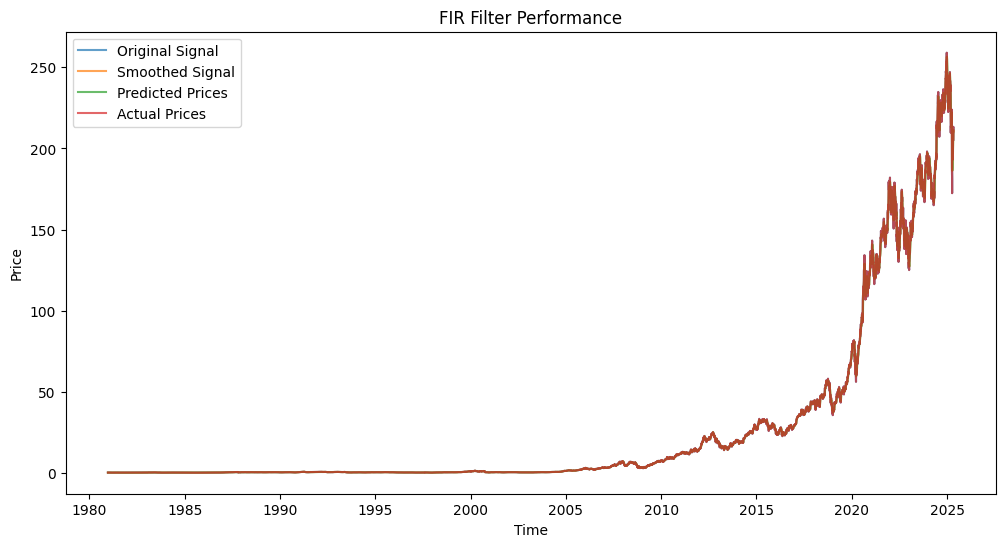

In [72]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
signal = data_clean["Close"]  # Original signal (e.g., stock closing prices)
smoothed = fir.filter(signal)  # Smoothed signal from FIR filter
predicted = smoothed.shift(1)  # Predicted prices (shifted smoothed signal)
actual = signal  # Actual prices (same as original signal)

# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size for clarity
plt.plot(signal.index, signal, label='Original Signal', alpha=0.7)
plt.plot(smoothed.index, smoothed, label='Smoothed Signal', alpha=0.7)
plt.plot(predicted.index, predicted, label='Predicted Prices', alpha=0.7)
plt.plot(actual.index, actual, label='Actual Prices', alpha=0.7)

# Add titles and labels
plt.title('FIR Filter Performance')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()  # Add a legend to distinguish the lines
plt.show()  # Display the plot

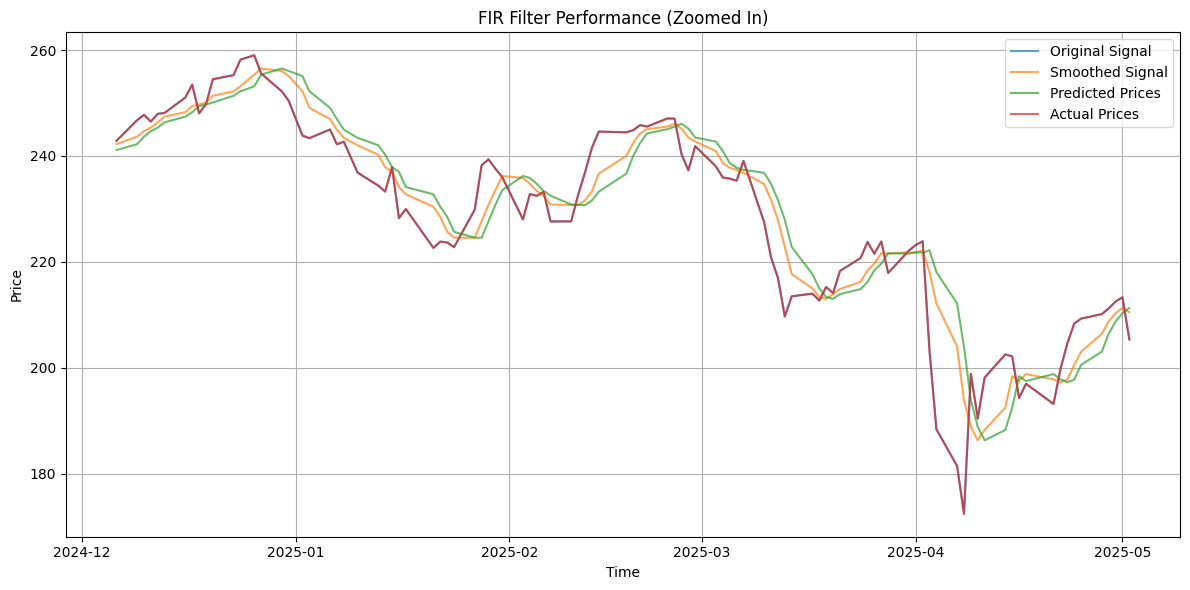

In [74]:
import matplotlib.pyplot as plt

# 原始数据
signal = data_clean["Close"]
smoothed = fir.filter(signal)
predicted = smoothed.shift(1)
actual = signal

# 限制显示区间（例如最后 100 个数据点）
plot_range = -100  # 你也可以用切片范围 like signal.loc['2020-01-01':'2021-01-01']

# 裁剪所有数据
signal_clip = signal.iloc[plot_range:]
smoothed_clip = smoothed.iloc[plot_range:]
predicted_clip = predicted.iloc[plot_range:]
actual_clip = actual.iloc[plot_range:]

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(signal_clip.index, signal_clip, label='Original Signal', alpha=0.7)
plt.plot(smoothed_clip.index, smoothed_clip, label='Smoothed Signal', alpha=0.7)
plt.plot(predicted_clip.index, predicted_clip, label='Predicted Prices', alpha=0.7)
plt.plot(actual_clip.index, actual_clip, label='Actual Prices', alpha=0.7)

plt.title('FIR Filter Performance (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
import numpy as np
import pandas as pd

# Define the evaluation function (as provided)
def evaluate_strategy_performance_real_world(y_real, y_real_pred, threshold=0.001, initial_capital=1_000_000):
    import numpy as np

    y_real = np.asarray(y_real)
    y_real_pred = np.asarray(y_real_pred)

    positions = np.where(y_real_pred > threshold, 1,
                 np.where(y_real_pred < -threshold, -1, 0))

    strategy_returns = positions * y_real

    cumsum_ret = np.clip(np.cumsum(strategy_returns), a_min=-50, a_max=50)

    dollar_returns = initial_capital * (np.exp(cumsum_ret) - 1)
    cum_return = np.exp(cumsum_ret) - 1

    std = np.std(strategy_returns)
    sharpe = 0.0 if std == 0 else np.mean(strategy_returns) / std * np.sqrt(252)

    summary = {
        "Real Cumulative Return": cum_return[-1],
        "Real Sharpe Ratio": sharpe
    }

    capital = {
        "Final Real Capital": dollar_returns[-1] + initial_capital,
        "Total Real Profit": dollar_returns[-1]
    }

    return summary, capital, positions, strategy_returns

# Assuming signal and smoothed are pandas Series (e.g., closing prices and FIR-filtered prices)
# Example: signal = pd.Series([...]), smoothed = pd.Series([...])

# Compute actual log returns
y_real = np.log(signal / signal.shift(1))

# Compute predicted log returns based on the trend in the smoothed signal
temp = np.log(smoothed / smoothed.shift(1))  # log return of smoothed signal
y_real_pred = temp.shift(1)  # shift forward so y_real_pred[t] uses data up to t-1

# Find the starting index where both series have valid (non-NaN) values
start_idx = max(y_real.first_valid_index(), y_real_pred.first_valid_index())

# Extract the valid portions of the series
y_real_valid = y_real[start_idx:]
y_real_pred_valid = y_real_pred[start_idx:]

# Call the function with the prepared inputs
summary, capital, positions, strategy_returns = evaluate_strategy_performance_real_world(
    y_real_valid, 
    y_real_pred_valid, 
    threshold=0.001,  # Default threshold
    initial_capital=1_000_000  # Default initial capital
)

# Extract and display the profit
profit = capital["Total Real Profit"]
print("Total Real Profit:", profit)

Total Real Profit: 1089289880.690844
